# This notebook is focused on implementing and examining the wavelet filtering and multiple linear regression procedure. 
## It contains a custom implementation of the MLR algorithm detailed in this paper: 
### Hu, L., Mouraux, A., Hu, Y., & Iannetti, G. D. (2010). A novel approach for enhancing the signal-to-noise ratio and detecting automatically event-related potentials (ERPs) in single trials. Neuroimage, 50(1), 99-111.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from fooof import FOOOF
from fooof import FOOOFGroup
import pickle
import pandas as pd
import mne
from lifelines import KaplanMeierFitter
from scipy.signal import detrend as scipy_detrend
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.signal import stft, istft
import scipy.signal as signal
from scipy.fftpack import fft

/var/folders/f0/yk_38ks9693585hklt0mrt9h0000gp/T/ipykernel_54587/2513994059.py:5: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [ ]:
# Load and average the data
directory_path = 'Path to processed files/Processed/'
files = os.listdir(directory_path)
to_process = [f for f in files if f.endswith('.set') and f.strip()]
print(len(to_process))

subfolder_name = 'Wavelet_Filtered'
Write_path = os.path.join(directory_path, subfolder_name)
if not os.path.exists(Write_path):
    os.makedirs(Write_path)
    print(f"Subfolder created at: {Write_path}")
else:
    print(f"Subfolder already exists at: {Write_path}")

# List to store the individual ERP data and their associated metadata
all_gafs_data = []
all_gafr_data = []
all_gafs_info = None  # This will store the info from the first ERP object
all_gafr_info = None  # This will store the info from the first ERP object
errors = []
indices = []
for this_subject in range(len(to_process)):
    subject_name = to_process[this_subject].split('.')[0][:8]
    try:
        epochs = mne.read_epochs_eeglab(directory_path + to_process[this_subject])
        epochs = epochs.crop(tmin=-.5, tmax = 1.5)
        epochs.apply_baseline(baseline = (-.5, 0))
        ERP = epochs.average()
        if 'GFAS' in subject_name:
            all_gafs_data.append(ERP.data)
            if all_gafs_info is None:
                all_gafs_info = ERP.info
                gafs_times = ERP.times
        if 'GFAR' in subject_name:
            all_gafr_data.append(ERP.data)
            if all_gafr_info is None:
                all_gafr_info = ERP.info
                gafr_times = ERP.times
    except:
        errors.append(subject_name)
        indices.append(this_subject)

# Stack all ERPs
all_gafs_data = np.stack(all_gafs_data, axis=0)
all_gafr_data = np.stack(all_gafr_data, axis=0)

# Create an MNE EvokedArray object
combined_gafs = mne.EvokedArray(all_gafs_data.mean(axis=0), all_gafs_info, tmin=gafs_times[0])
combined_gafr = mne.EvokedArray(all_gafr_data.mean(axis=0), all_gafr_info, tmin=gafr_times[0])

# Save the grand averages as .fif files
combined_gafs.save('Path to processed files/Processed/GFAS_Grand_Average.fif')
combined_gafr.save('Path to processed files/Processed/GFAR_Grand_Average.fif')

print(f'Errors in the following subjects: {errors}')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


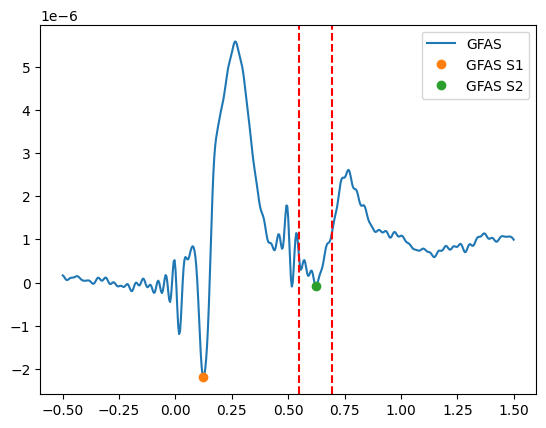

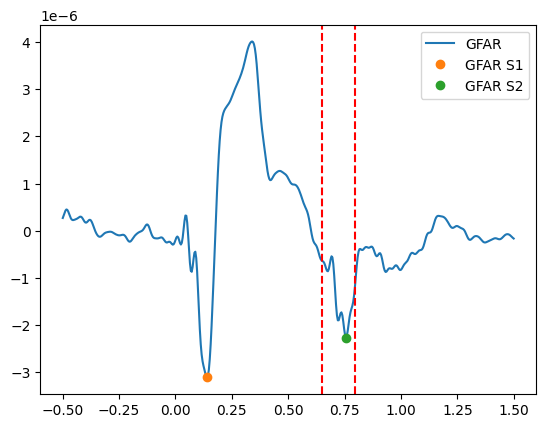

Powspect shape is (51, 502)


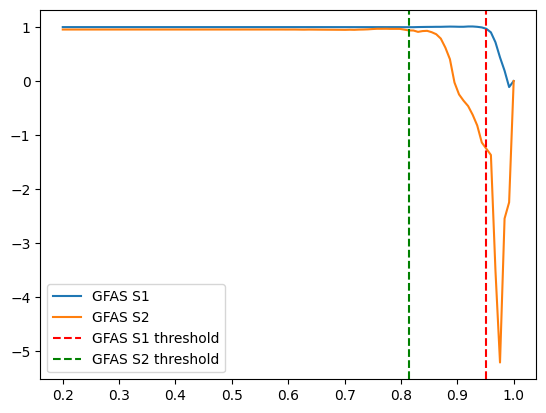

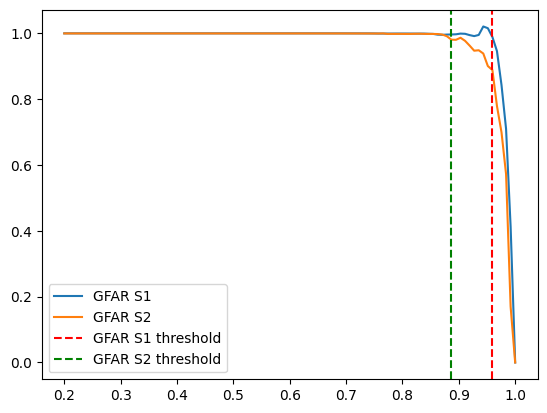

In [6]:
############################### Extracting the mask and establishing a threshold ###############################
# Function to extract a mask based on the CDF of the power spectrum
def extract_mask(powspect,threshold = .90, plot_cdf = False):
    # Normalize the power spectrum along the time and frequency dimensions
    powspect = np.abs(powspect)
    normalized_powspect = powspect / np.max(powspect, keepdims=True)
    flattened_powspect = normalized_powspect.flatten()
    kmf = KaplanMeierFitter()
    kmf.fit(flattened_powspect, event_observed=np.ones_like(flattened_powspect))

    cdf = 1 - kmf.survival_function_.values
    times = kmf.survival_function_.index.values
    
    # Retrieve the empirical CDF
    cdf_values = 1 - kmf.survival_function_.reindex(flattened_powspect, method="nearest").values.flatten()
    cdf_matrix = cdf_values.reshape(normalized_powspect.shape)

    # Define thresholds based on the reshaped CDF matrices
    threshold = threshold * (cdf_matrix.max() - cdf_matrix.min()) + cdf_matrix.min()
    if plot_cdf:
        plt.plot(times, cdf)
        plt.axhline(y = threshold, color = 'r', linestyle = '--')
        plt.show()
    # Create masks for filtering
    mask = cdf_matrix > threshold
    return mask

# Load the grand averages
combined_gafs = mne.read_evokeds('Path to processed files/Processed/GFAS_Grand_Average.fif')[0]
combined_gafr = mne.read_evokeds('Path to processed files/Processed/GFAR_Grand_Average.fif')[0]

# Test the effect of the threshold on the peak amplitudes
fs = combined_gafs.info['sfreq']  # Sampling frequency
t = epochs.times
chan2process_gafs = 128
chan2process_gafr = 128
combined_gafr.apply_baseline(baseline = (-.5, 0))
combined_gafs.apply_baseline(baseline = (-.5, 0))
signal_gafs = combined_gafs.get_data()[chan2process_gafs,:]
signal_gafr = combined_gafr.get_data()[chan2process_gafr,:]

# Identify peaks in the time domain
S1_GFAS_onset = np.argmin(np.abs(t - 0))
S2_GFAS_onset = np.argmin(np.abs(t - 0.55))
S1_GFAR_onset = np.argmin(np.abs(t - 0))
S2_GFAR_onset = np.argmin(np.abs(t - 0.65))

########### This is the window within which we are looking for the peak in the grand average ###########
window_size = int(0.15*fs) ############# Change this window for the relevant peak ######################

GFAS_S1 =  np.min(signal_gafs[S1_GFAS_onset:S1_GFAS_onset + window_size])
GFAS_S2 =  np.min(signal_gafs[S2_GFAS_onset:S2_GFAS_onset + window_size])
GFAR_S1 =  np.min(signal_gafr[S1_GFAR_onset:S1_GFAR_onset + window_size])
GFAR_S2 =  np.min(signal_gafr[S2_GFAR_onset:S2_GFAR_onset + window_size])

GFAS_S1_latency = np.argmin(signal_gafs[S1_GFAS_onset:S1_GFAS_onset + window_size]) + S1_GFAS_onset
GFAS_S2_latency = np.argmin(signal_gafs[S2_GFAS_onset:S2_GFAS_onset + window_size]) + S2_GFAS_onset
GFAR_S1_latency = np.argmin(signal_gafr[S1_GFAR_onset:S1_GFAR_onset + window_size]) + S1_GFAR_onset
GFAR_S2_latency = np.argmin(signal_gafr[S2_GFAR_onset:S2_GFAR_onset + window_size]) + S2_GFAR_onset

plt.plot(t,signal_gafs, label = 'GFAS')
plt.plot(t[GFAS_S1_latency], GFAS_S1, 'o', label = 'GFAS S1')
plt.plot(t[GFAS_S2_latency], GFAS_S2, 'o', label = 'GFAS S2')
plt.axvline(x = t[S2_GFAS_onset], color = 'r', linestyle = '--')
plt.axvline(x = t[S2_GFAS_onset + window_size], color = 'r', linestyle = '--')
plt.legend()
plt.show()

plt.plot(t,signal_gafr, label = 'GFAR')
plt.plot(t[GFAR_S1_latency], GFAR_S1, 'o', label = 'GFAR S1')
plt.plot(t[GFAR_S2_latency], GFAR_S2, 'o', label = 'GFAR S2')
plt.legend()
plt.axvline(x = t[S2_GFAR_onset], color = 'r', linestyle = '--')
plt.axvline(x = t[S2_GFAR_onset + window_size], color = 'r', linestyle = '--')
plt.show()

# STFT: Transform to time-frequency domain
f, time_GFAS, powspect_gafs = stft(signal_gafs, fs=fs, nperseg=100, noverlap=99, boundary='zeros')
f, time_GFAR, powspect_gafr = stft(signal_gafr, fs=fs, nperseg=100, noverlap=99, boundary='zeros')
# Create a time vector from -.5 to 1.5 in shape powspect_gafs steps
time_GFAS = np.linspace(-.5, 1.5, powspect_gafs.shape[1])
time_GFAR = np.linspace(-.5, 1.5, powspect_gafr.shape[1])
print(f'Powspect shape is {powspect_gafs.shape}')

# Baseline correct the data
# one second before the stimulus onset
baseline_window = int(np.argmin(np.abs(time_GFAS - (-.5))))
baseline_data_GFAS = powspect_gafs[:,baseline_window:baseline_window + int(fs*.4)].mean(axis=1, keepdims=True)
baseline_data_GFAR = powspect_gafr[:,baseline_window:baseline_window + int(fs*.4)].mean(axis=1, keepdims=True)

powspect_gafs = powspect_gafs - baseline_data_GFAS
powspect_gafr = powspect_gafr - baseline_data_GFAR

Relative_GFAS_S1 = []
Relative_GFAS_S2 = []
Relative_GFAR_S1 = []
Relative_GFAR_S2 = []
Threshold_values = np.linspace(.2, 1.00, 100)

for thresh in Threshold_values:
    mask_gafs = extract_mask(powspect_gafs, threshold = thresh, plot_cdf = False)
    mask_gafr = extract_mask(powspect_gafr, threshold = thresh, plot_cdf = False)

    # Apply the mask to the time-frequency data and perform the inverse transform
    powspect_gafs_filtered = powspect_gafs * mask_gafs
    powspect_gafr_filtered = powspect_gafr * mask_gafr

    _, signal_gafs_filtered = istft(powspect_gafs_filtered, fs=fs, nperseg=100, noverlap=99, boundary='zeros')
    _, signal_gafr_filtered = istft(powspect_gafr_filtered, fs=fs, nperseg=100, noverlap=99, boundary='zeros')

    assert signal_gafs_filtered.shape == signal_gafs.shape
    assert signal_gafr_filtered.shape == signal_gafr.shape

    # manually baseline correct the filtered data
    base_start = np.argmin(np.abs(t - (-.5)))
    base_end = np.argmin(np.abs(t - 0))
    signal_gafs_filtered = signal_gafs_filtered - np.mean(signal_gafs_filtered[base_start:base_end])
    signal_gafr_filtered = signal_gafr_filtered - np.mean(signal_gafr_filtered[base_start:base_end])

    # Compute the peak at the same laency as the unfiltered data
    GFAS_S1_filtered = signal_gafs_filtered[int(GFAS_S1_latency)]
    GFAS_S2_filtered = signal_gafs_filtered[int(GFAS_S2_latency)]
    GFAR_S1_filtered = signal_gafr_filtered[int(GFAR_S1_latency)]
    GFAR_S2_filtered = signal_gafr_filtered[int(GFAR_S2_latency)]

    Relative_GFAS_S1.append(GFAS_S1_filtered/GFAS_S1)
    Relative_GFAS_S2.append(GFAS_S2_filtered/GFAS_S2)
    Relative_GFAR_S1.append(GFAR_S1_filtered/GFAR_S1)
    Relative_GFAR_S2.append(GFAR_S2_filtered/GFAR_S2)
    
# Corrected code to find the first threshold where values drop below 0.99
GFAS_threshold_S1 = Threshold_values[np.argmax(np.array(Relative_GFAS_S1) < 0.99*Relative_GFAS_S1[0])]
GFAS_threshold_S2 = Threshold_values[np.argmax(np.array(Relative_GFAS_S2) < 0.99*Relative_GFAS_S2[0])]
GFAR_threshold_S1 = Threshold_values[np.argmax(np.array(Relative_GFAR_S1) < 0.99*Relative_GFAR_S1[0])]
GFAR_threshold_S2 = Threshold_values[np.argmax(np.array(Relative_GFAR_S2) < 0.99*Relative_GFAR_S2[0])]

plt.plot(Threshold_values, Relative_GFAS_S1, label = 'GFAS S1')
plt.plot(Threshold_values, Relative_GFAS_S2, label = 'GFAS S2')
plt.axvline(x = GFAS_threshold_S1, color = 'r', linestyle = '--', label = 'GFAS S1 threshold')
plt.axvline(x = GFAS_threshold_S2, color = 'g', linestyle = '--', label = 'GFAS S2 threshold')
plt.legend()
plt.show()

plt.plot(Threshold_values, Relative_GFAR_S1, label = 'GFAR S1')
plt.plot(Threshold_values, Relative_GFAR_S2, label = 'GFAR S2')
plt.axvline(x = GFAR_threshold_S1, color = 'r', linestyle = '--', label = 'GFAR S1 threshold')
plt.axvline(x = GFAR_threshold_S2, color = 'g', linestyle = '--', label = 'GFAR S2 threshold')
plt.legend()
plt.show()

# Extract the mask for the final threshold
Final_Threshold_GFAS = np.min([GFAS_threshold_S1, GFAS_threshold_S2]) # Check if this is okay for the threshold calculation
Final_Threshold_GFAR = np.min([GFAR_threshold_S1, GFAR_threshold_S2])

mask_gafs = extract_mask(powspect_gafs, threshold = Final_Threshold_GFAS, plot_cdf = False)
mask_gafr = extract_mask(powspect_gafr, threshold = Final_Threshold_GFAR, plot_cdf = False)

f, time_segments, Zxx = stft(signal_gafs, fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros', axis=-1)
Zxx_filtered = Zxx * mask_gafs
_, signal_gafs_filtered = istft(Zxx_filtered, fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros')
signal_gafs_filtered = signal_gafs_filtered - np.mean(signal_gafs_filtered[base_start:base_end])

f, time_segments, Zxx = stft(signal_gafr, fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros', axis=-1)
Zxx_filtered = Zxx * mask_gafr
_, signal_gafr_filtered = istft(Zxx_filtered, fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros')
signal_gafr_filtered = signal_gafr_filtered - np.mean(signal_gafr_filtered[base_start:base_end])

assert signal_gafs_filtered.shape == signal_gafs.shape
assert signal_gafr_filtered.shape == signal_gafr.shape


In [ ]:
######################## Apply the mask to the single trial data of each participant ########################
directory_path = 'Path to processed files/Processed/'
Write_path = directory_path + 'Wavelet_Filtered/'
files = os.listdir(directory_path)
to_process = [f for f in files if f.endswith('.set') and f.strip()]
print(len(to_process))

errors = []
indices = []
all_gafs_filtered_data = {}
all_gafr_filtered_data = {}
for this_subject in range(len(to_process)):
    if to_process[this_subject].startswith('.'):
        continue
    if 'GFAS' in to_process[this_subject]:
        chan2process = 128 ########## Change this to the relevant channel ##########
    else:
        chan2process = 128 ########## Change this to the relevant channel ##########
    try:
        epochs = mne.read_epochs_eeglab(directory_path + to_process[this_subject])
        epochs = epochs.crop(tmin = -.5, tmax = 1.5)
        subject_name = to_process[this_subject].split('.')[0][:8]
        epochs.apply_baseline(baseline = (-.5, 0))
        signal = epochs.get_data()[:,chan2process,:]
        f, time_segments, Zxx = stft(signal, fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros', axis=-1)
        if 'GFAS' in subject_name:
            Zxx_filtered = Zxx * mask_gafs
            reconstructed_signals = np.zeros_like(signal)
            for i in range(Zxx_filtered.shape[0]):
                _, reconstructed_signals[i,:] = istft(Zxx_filtered[i,:,:], fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros', time_axis=1, freq_axis=0)
                base_start = np.argmin(np.abs(epochs.times - (-.5)))
                base_end = np.argmin(np.abs(epochs.times - (0)))
                reconstructed_signals[i,:] = reconstructed_signals[i,:] - np.mean(reconstructed_signals[i,base_start:base_end])
            all_gafs_filtered_data[subject_name] = reconstructed_signals
        if 'GFAR' in subject_name:
            Zxx_filtered = Zxx * mask_gafr
            reconstructed_signals = np.zeros_like(signal)
            for i in range(Zxx_filtered.shape[0]):
                _, reconstructed_signals[i,:] = istft(Zxx_filtered[i,:,:], fs=epochs.info['sfreq'], nperseg=100, noverlap=99, boundary='zeros', time_axis=1, freq_axis=0)
                # baseline correct the filtered data
                base_start = np.argmin(np.abs(epochs.times - (-.5)))
                base_end = np.argmin(np.abs(epochs.times - (0)))
                reconstructed_signals[i,:] = reconstructed_signals[i,:] - np.mean(reconstructed_signals[i,base_start:base_end])
            all_gafr_filtered_data[subject_name] = reconstructed_signals
    except:
        errors.append(subject_name)
        indices.append(this_subject)

all_gafs_filtered_data['srate'] = epochs.info['sfreq']
all_gafr_filtered_data['srate'] = epochs.info['sfreq']
all_gafs_filtered_data['Times'] = epochs.times
all_gafr_filtered_data['Times'] = epochs.times

# # Save the filtered data
# output_path = os.path.join(Write_path, "all_gafr_filtered_data.pkl")
# with open(output_path, 'wb') as f:
#     pickle.dump(all_gafr_filtered_data, f)

# output_path = os.path.join(Write_path, "all_gafs_filtered_data.pkl")
# with open(output_path, 'wb') as f:
#     pickle.dump(all_gafs_filtered_data, f)

# print(f"Filtered data saved to: {output_path}")
# print(f"Errors encountered for subjects: {errors}")


0.16

In [581]:
# Performing MLR  on the filered dataand storing the extracted parameters
# Modify the initial dictionaries to include a nested structure for stimuli
filtered_path = 'Path to processed files/Processed/Wavelet_Filtered/'
all_gafs_filtered_data = pickle.load(open(filtered_path + 'all_gafs_filtered_data.pkl', 'rb'))
all_gafr_filtered_data = pickle.load(open(filtered_path + 'all_gafr_filtered_data.pkl', 'rb'))

Fitted_responses_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}
ERP_peaks_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}
ERP_latencies_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}
Original_ERP_peaks_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}
Original_ERP_latencies_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}
Coefficients_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}
Residuals_GFAS = {subname: {} for subname in all_gafs_filtered_data.keys() if subname not in ['srate', 'Times']}

Fitted_responses_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}
ERP_peaks_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}
ERP_latencies_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}
Original_ERP_peaks_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}
Original_ERP_latencies_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}
Coefficients_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}
Residuals_GFAR = {subname: {} for subname in all_gafr_filtered_data.keys() if subname not in ['srate', 'Times']}

Modalities = ['GFAS', 'GFAR']
Stims = ['S1', 'S2']
with_intercept = True
Reg_Grandave = True
Neg_coeffs = []
half_win = int(.08*fs)

for Modality in Modalities:
    if Modality == 'GFAS':
        All_dat = all_gafs_filtered_data
        Grand_average = signal_gafs_filtered
        S1_latency = int(GFAS_S1_latency)
        S2_latency = int(GFAS_S2_latency)
    else: 
        All_dat = all_gafr_filtered_data
        Grand_average = signal_gafr_filtered
        S1_latency = int(GFAR_S1_latency)
        S2_latency = int(GFAR_S2_latency)
    
    for subname in All_dat.keys():
        if subname not in ['srate', 'Times']:
            data = All_dat[subname]
            fs = All_dat['srate']
            times = All_dat['Times']

            for Stim in Stims:
                if Stim == 'S1':
                    if Reg_Grandave:
                        onset = times[int(S1_latency - half_win)]
                    else:
                        onset = 0
                elif Stim == 'S2':
                    if Modality == 'GFAS':
                        if Reg_Grandave:
                            onset = times[int(S2_latency - half_win)]
                        else:
                            onset = 0.5
                    else:
                        if Reg_Grandave:
                            onset = times[int(S2_latency - half_win)]
                        else:
                            onset = 0.65
                window_size = half_win*2 # Change this if you want to only explore 150 ms windows
                Win_start = np.argmin(np.abs(times - onset))
                Win_end = Win_start + window_size

                # Slice data for the specific window
                data_windowed = data[:, Win_start:Win_end]

                # Create the regressors
                if with_intercept:
                    regressors = np.zeros((data_windowed.shape[1], 3))  
                    regressors[:, 0] = 1  # Intercept column
                    if Reg_Grandave:
                        regressors[:, 1] = Grand_average[Win_start:Win_end]
                        regressors[:, 2] = np.concatenate([np.array([0]), np.diff(regressors[:, 1])])
                    else:
                        regressors[:, 1] = data_windowed.mean(axis=0)
                        regressors[:, 2] = np.concatenate([np.array([0]), np.diff(regressors[:, 1])])
                else:
                    regressors = np.zeros((data_windowed.shape[1], 2))  
                    if Reg_Grandave:
                        regressors[:,0] = Grand_average[Win_start:Win_end]
                        regressors[:,1] = np.concatenate([np.array([0]), np.diff(regressors[:, 0])])
                    else:
                        regressors[:, 0] = data_windowed.mean(axis=0)
                        regressors[:, 1] = np.concatenate([np.array([0]), np.diff(regressors[:, 0])])
                    

                # MLR
                beta = np.zeros((data_windowed.shape[0], regressors.shape[1]))
                residuals = np.zeros((data_windowed.shape[0],1))
                for trial in range(data_windowed.shape[0]):
                    y = data_windowed[trial, :]
                    beta[trial, :], residuals[trial], _, _ = np.linalg.lstsq(regressors, y, rcond=None)
                fitted_responses = np.dot(beta, regressors.T)
                assert fitted_responses.shape == data_windowed.shape

                # ERP peak and latency from regressor
                if with_intercept:
                    erp_peak = np.min(regressors[:, 1])
                    erp_latency = np.argmin(regressors[:, 1])
                else:
                    erp_peak = np.min(regressors[:, 0])
                    erp_latency = np.argmin(regressors[:, 0])

                # Calculate peaks and latencies
                winofinterest = [int(erp_latency - 0.06 * fs), int(erp_latency + 0.06 * fs)]
                winofinterest[0] = np.max([0, winofinterest[0]])
                winofinterest[1] = np.min([len(regressors), winofinterest[1]])
                peaks = np.zeros((fitted_responses.shape[0], 1))
                latencies = np.zeros((fitted_responses.shape[0], 1))
                if with_intercept:
                    for trial in range(fitted_responses.shape[0]):
                        if beta[trial, 1] < 0:
                            peaks[trial, 0] = np.max(fitted_responses[trial, winofinterest[0]:winofinterest[1]])
                            latencies[trial, 0] = np.argmax(fitted_responses[trial, winofinterest[0]:winofinterest[1]]) + winofinterest[0]
                            Neg_coeffs.append(trial)
                        else:
                            peaks[trial, 0] = np.min(fitted_responses[trial, winofinterest[0]:winofinterest[1]])
                            latencies[trial, 0] = np.argmin(fitted_responses[trial, winofinterest[0]:winofinterest[1]]) + winofinterest[0]
                else:
                    for trial in range(fitted_responses.shape[0]):
                        if beta[trial, 0] < 0:
                            peaks[trial, 0] = np.max(fitted_responses[trial, winofinterest[0]:winofinterest[1]])
                            latencies[trial, 0] = np.argmax(fitted_responses[trial, winofinterest[0]:winofinterest[1]]) + winofinterest[0]
                            Neg_coeffs.append(trial)
                        else:
                            peaks[trial, 0] = np.min(fitted_responses[trial, winofinterest[0]:winofinterest[1]])
                            latencies[trial, 0] = np.argmin(fitted_responses[trial, winofinterest[0]:winofinterest[1]]) + winofinterest[0]

                # Adjust latencies to be relative to the window start
                latencies += Win_start
                erp_latency += Win_start
                
                # Store results with nested structure for stimuli
                if Modality == 'GFAS':
                    Fitted_responses_GFAS[subname][Stim] = fitted_responses
                    ERP_peaks_GFAS[subname][Stim] = peaks[:,0]
                    ERP_latencies_GFAS[subname][Stim] = latencies[:,0]
                    Original_ERP_peaks_GFAS[subname][Stim] = erp_peak
                    Original_ERP_latencies_GFAS[subname][Stim] = erp_latency
                    Coefficients_GFAS[subname][Stim] = beta
                    Residuals_GFAS[subname][Stim] = residuals[:,0]
                else:  # 'GFAR'
                    Fitted_responses_GFAR[subname][Stim] = fitted_responses
                    ERP_peaks_GFAR[subname][Stim] = peaks[:,0]
                    ERP_latencies_GFAR[subname][Stim] = latencies[:,0]
                    Original_ERP_peaks_GFAR[subname][Stim] = erp_peak
                    Original_ERP_latencies_GFAR[subname][Stim] = erp_latency
                    Coefficients_GFAR[subname][Stim] = beta
                    Residuals_GFAR[subname][Stim] = residuals[:,0]

In [10]:
# Put the MLR algorithm in a function
def perform_mlr(data, times, fs, regressor_data, Stim_onset_sec = 0, Win_for_peak_sec=.15,
                with_intercept=True, Half_win_around_peak_sec=0.06, Artifact_offset_sec=0):
    
    """"
    Returns
    -------
    results : dict
        Dictionary containing the following keys:
          - 'fitted_responses': Fitted responses (n_trials × window_length).
          - 'peaks': Single-trial peak values (1D array).
          - 'latencies': Single-trial latency indices (1D array).
          - 'original_peak': ERP peak (scalar) from the regressor signal.
          - 'original_latency': ERP latency (scalar) from the regressor signal.
          - 'coefficients': Regression coefficients (n_trials × n_regressors).
          - 'residuals': Residuals (1D array).
          - 'neg_coeff_trials': List of trial indices with a negative coefficient (for the relevant regressor).
          - 'Win_start': Start index of the data window.
          - 'Win_end': End index of the data window.
    """

    Regressor_ERP = regressor_data.mean(axis=0)
    Peakwin_start_samp = np.argmin(np.abs(times - (Stim_onset_sec+Artifact_offset_sec)))
    Peakwin_end_samp = Peakwin_start_samp + int(Win_for_peak_sec*fs)
    peak_latency_samp = np.argmin(Regressor_ERP[Peakwin_start_samp:Peakwin_end_samp]) + Peakwin_start_samp
    peak_amplitude = np.min(Regressor_ERP[Peakwin_start_samp:Peakwin_end_samp])
    peak_latency_sec = times[peak_latency_samp]

    # Calculate the subject specific ERP peak and latency
    Subject_ERP = data.mean(axis=0)
    Subject_ERP_peak_latency_samp = np.argmin(Subject_ERP[Peakwin_start_samp:Peakwin_end_samp]) + Peakwin_start_samp
    Subject_ERP_peak_latency_sec = times[Subject_ERP_peak_latency_samp]
    Subject_ERP_peak_amplitude = np.min(Subject_ERP[Peakwin_start_samp:Peakwin_end_samp])

    # Slice the data for the selected time window
    data_windowed = data[:, Peakwin_start_samp:Peakwin_end_samp]
    n_timepoints = data_windowed.shape[1]

    # Build the regressors
    if with_intercept:
        regressors = np.zeros((n_timepoints, 3))
        regressors[:, 0] = 1  # intercept column
        regressors[:, 1] = Regressor_ERP[Peakwin_start_samp:Peakwin_end_samp]
        regressors[:, 2] = np.concatenate(([0], np.diff(regressors[:, 1])))
    else:
        regressors = np.zeros((n_timepoints, 2))
        regressors[:, 0] = Regressor_ERP[Peakwin_start_samp:Peakwin_end_samp]
        regressors[:, 1] = np.concatenate(([0], np.diff(regressors[:, 0])))

    # Run MLR for each trial
    n_trials = data_windowed.shape[0]
    n_regressors = regressors.shape[1]
    beta = np.zeros((n_trials, n_regressors))
    residuals = np.zeros((n_trials, 1))
    for trial in range(n_trials):
        y = data_windowed[trial, :]
        beta[trial, :], residuals[trial], _, _ = np.linalg.lstsq(regressors, y, rcond=None)
    fitted_responses = np.dot(beta, regressors.T)
    if fitted_responses.shape != data_windowed.shape:
        raise ValueError("Fitted responses shape mismatch.")

    # Define a window of interest around the ERP latency (±peak_window_sec)
    win_ext = int(Half_win_around_peak_sec * fs)
    temp_peak_latency_samp = np.argmin(Regressor_ERP[Peakwin_start_samp:Peakwin_end_samp])
    win_of_interest = [max(0, temp_peak_latency_samp - win_ext), min(n_timepoints, temp_peak_latency_samp + win_ext)]

    # Initialize arrays for trial-by-trial peak and latency measures.
    peaks = np.zeros((n_trials, 1))
    latencies = np.zeros((n_trials, 1))
    neg_coeff_trials = []
    # Determine which regression coefficient to inspect based on with_intercept.
    coeff_idx = 1 if with_intercept else 0
    for trial in range(n_trials):
        if beta[trial, coeff_idx] < 0:
            neg_coeff_trials.append(trial)
            # If the coefficient is negative, take the maximum in the window.
            peaks[trial, 0] = np.max(fitted_responses[trial, win_of_interest[0]:win_of_interest[1]])
            latencies[trial, 0] = np.argmax(fitted_responses[trial, win_of_interest[0]:win_of_interest[1]]) + win_of_interest[0]
        else:
            peaks[trial, 0] = np.min(fitted_responses[trial, win_of_interest[0]:win_of_interest[1]])
            latencies[trial, 0] = np.argmin(fitted_responses[trial, win_of_interest[0]:win_of_interest[1]]) + win_of_interest[0]

    # Adjust latencies to be relative to the original data timeline
    latencies += Peakwin_start_samp

    results = {
        'fitted_responses': fitted_responses,
        'peaks': peaks.flatten(),
        'latencies': latencies.flatten(),
        'original_peak': Subject_ERP_peak_amplitude,
        'original_latency': Subject_ERP_peak_latency_samp,
        'coefficients': beta,
        'residuals': residuals.flatten(),
        'neg_coeff_trials': neg_coeff_trials,
        'Win_start': Peakwin_start_samp,
        'Win_end': Peakwin_end_samp
    }
    return results


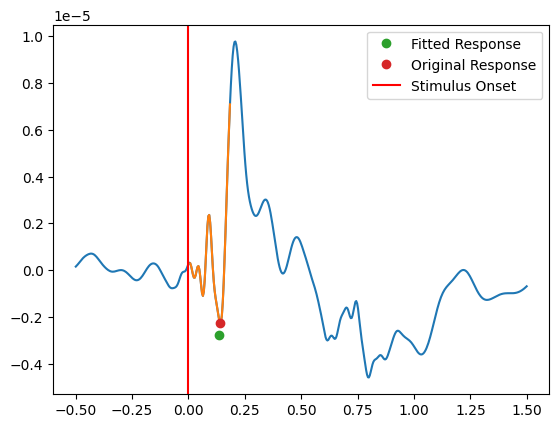

In [21]:
# Testing the function
# filtered_path = 'Path to processed files/Processed/Wavelet_Filtered/'
# all_gafs_filtered_data = pickle.load(open(filtered_path + 'all_gafs_filtered_data.pkl', 'rb'))
# all_gafr_filtered_data = pickle.load(open(filtered_path + 'all_gafr_filtered_data.pkl', 'rb'))

Subject_Data = all_gafr_filtered_data['GFAR_009']
Times = all_gafr_filtered_data['Times']
fs = all_gafr_filtered_data['srate']
Onset = 0
Artifact_offset = .01
Test_regression = perform_mlr(data = Subject_Data, times = Times, fs = fs, regressor_data=Subject_Data, Stim_onset_sec = Onset, Win_for_peak_sec=.18,
                with_intercept=False, Half_win_around_peak_sec=0.06, Artifact_offset_sec=Artifact_offset)

Test_regression.keys()
trial = 8
plt.plot(Times, Subject_Data.mean(axis=0))
plt.plot(Times[Test_regression['Win_start']:Test_regression['Win_end']], Test_regression['fitted_responses'].mean(axis=0))
plt.plot(Times[int(Test_regression['latencies'].mean())], Test_regression['peaks'].mean(), 'o', label='Fitted Response')
plt.plot(Times[int(Test_regression['original_latency'])], Test_regression['original_peak'], 'o', label='Original Response')
plt.axvline(x = Onset, color = 'r', label = 'Stimulus Onset')
plt.legend()
plt.show()

In [42]:
# Perform MLR for all subjects
Modalities = ['GFAS', 'GFAR']
Stims = ['S1', 'S2']
with_intercept = False

MLR_results_GFAS = {}
MLR_results_GFAR = {}

for Modality in Modalities:
    if Modality == 'GFAS':
        All_dat = all_gafs_filtered_data
        Grand_average = signal_gafs_filtered  # your grand average signal for GFAS
    else:  # GFAR
        All_dat = all_gafr_filtered_data
        Grand_average = signal_gafr_filtered  # your grand average signal for GFAR

    for subname in All_dat.keys():
        if subname not in ['srate', 'Times']:
            data = All_dat[subname]
            fs = All_dat['srate']
            Times = All_dat['Times']

            for Stim in Stims:
                if Stim == 'S1':
                    onset = 0  # Not used for S1 when reg_grandave is False
                elif Stim == 'S2':
                    if Modality == 'GFAS':
                        onset = 0.5
                        Artifact_offset = .01
                    else:
                        onset = 0.65
                        Artifact_offset = 0

                mlr_results = perform_mlr(data = Subject_Data, times = Times, fs = fs, regressor_data=Subject_Data, Stim_onset_sec = Onset, Win_for_peak_sec=.18,
                with_intercept=True, Half_win_around_peak_sec=0.06, Artifact_offset_sec=0)

                # Store the results in your nested dictionaries as needed.
                if Modality == 'GFAS':
                    MLR_results_GFAS[subname][Stim] = mlr_results
                else:  # GFAR
                    MLR_results_GFAR[subname][Stim] = mlr_results

np.float64(752.6086956521739)

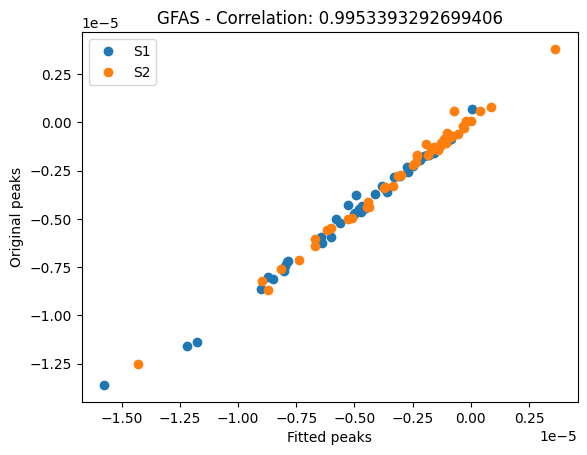

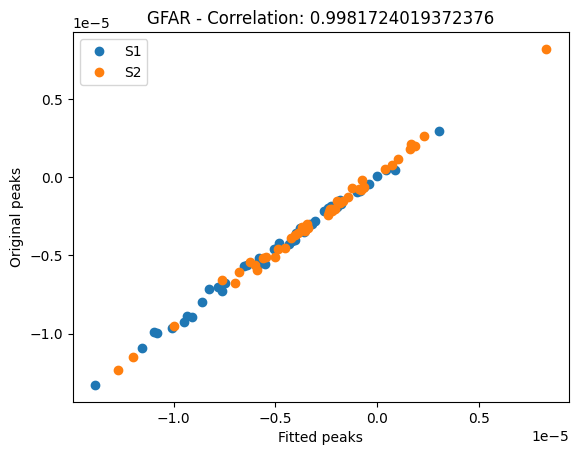

In [558]:
# Plot the corrospondance between fitted and original peaks
name = list(all_gafs_filtered_data.keys())[1]
Stims = ['S1', 'S2']
for stim in Stims:
    fitted_peaks = []
    original_peaks = []
    for name in ERP_peaks_GFAS.keys():
        if name not in ['srate', 'Times']:
            fitted_peaks.append(ERP_peaks_GFAS[name][stim].mean(axis=0))
            original_peaks.append(Original_ERP_peaks_GFAS[name][stim])
    plt.plot(fitted_peaks, original_peaks, 'o')
plt.xlabel('Fitted peaks')
plt.ylabel('Original peaks')
plt.title(f'GFAS - Correlation: {np.corrcoef(np.array(fitted_peaks).squeeze(), np.array(original_peaks).squeeze())[0,1]}')
plt.legend(Stims)
plt.show()

name = list(all_gafr_filtered_data.keys())[1]
Stims = ['S1', 'S2']
for stim in Stims:
    fitted_peaks = []
    original_peaks = []
    for name in ERP_peaks_GFAR.keys():
        if name not in ['srate', 'Times']:
            fitted_peaks.append(ERP_peaks_GFAR[name][stim].mean(axis=0))
            original_peaks.append(Original_ERP_peaks_GFAR[name][stim])
    plt.plot(fitted_peaks, original_peaks, 'o')
plt.xlabel('Fitted peaks')
plt.ylabel('Original peaks')
plt.title(f'GFAR - Correlation: {np.corrcoef(np.array(fitted_peaks).squeeze(), np.array(original_peaks).squeeze())[0,1]}')
plt.legend(Stims)
plt.show()

In [587]:
################################## Construct the excel sheet for all the data together ##################################

Path = 'Path to processed files/Processed/Features_Thesis/'
# Extract all .pkl files
pkl_files = [f for f in os.listdir(Path) if f.endswith('.pkl')]
GFAR_subjects = list(ERP_peaks_GFAR.keys())
GFAS_subjects = list(ERP_peaks_GFAS.keys())
times = all_gafs_filtered_data['Times']

for index, pkl_file in enumerate(pkl_files):
    with open(Path + '/' + pkl_file, 'rb') as f: 
        loaded_results_dict = pickle.load(f)
    Condition = pkl_file.split('_')[0]
    Participant = pkl_file[:8]

    if Condition == 'GFAS':
        channel2xtract = 128
        index_in_keys = GFAS_subjects.index(Participant)
        Original_ERP_S1 = Original_ERP_peaks_GFAS[Participant]['S1']
        Original_ERP_S1_latency = Original_ERP_latencies_GFAS[Participant]['S1']
        Original_ERP_S2 = Original_ERP_peaks_GFAS[Participant]['S2']
        Original_ERP_S2_latency = Original_ERP_latencies_GFAS[Participant]['S2']
        Fitted_S1 = ERP_peaks_GFAS[Participant]['S1']
        Fitted_S1_latency = ERP_latencies_GFAS[Participant]['S1']
        Fitted_S2 = ERP_peaks_GFAS[Participant]['S2']
        Fitted_S2_latency = ERP_latencies_GFAS[Participant]['S2']
    else:
        channel2xtract = 128
        index_in_keys = GFAR_subjects.index(Participant)
        Original_ERP_S1 = Original_ERP_peaks_GFAR[Participant]['S1']
        Original_ERP_S1_latency = Original_ERP_latencies_GFAR[Participant]['S1']
        Original_ERP_S2 = Original_ERP_peaks_GFAR[Participant]['S2']
        Original_ERP_S2_latency = Original_ERP_latencies_GFAR[Participant]['S2']
        Fitted_S1 = ERP_peaks_GFAR[Participant]['S1']
        Fitted_S1_latency = ERP_latencies_GFAR[Participant]['S1']
        Fitted_S2 = ERP_peaks_GFAR[Participant]['S2']
        Fitted_S2_latency = ERP_latencies_GFAR[Participant]['S2']

    numtrials = len(loaded_results_dict['alpha_power'])
    
    alpha_power = loaded_results_dict['alpha_power'][:,channel2xtract,:].mean(axis=1)
    Exponents = []
    Offsets = []
    for trial in range(numtrials):
        tempdata = loaded_results_dict[(trial, channel2xtract)]
        # aperiodic_params, peak_params, r_squared, error, gaussian_params
        aperiodic_params = tempdata['aperiodic_params']
        Exponents.append(aperiodic_params[1])
        Offsets.append(aperiodic_params[0])
    Exponents = np.array(Exponents)
    Offsets = np.array(Offsets)
    Theta_Gating = loaded_results_dict['theta_gating'][:,channel2xtract]

    assert len(Theta_Gating) == Exponents.shape[0] == Offsets.shape[0] == alpha_power.shape[0] == len(Fitted_S1) == len(Fitted_S2), "The lengths of the arrays do not match"

    data = []
    for trial in range(numtrials):
        trial_data = {
            "Participant": Participant,
            "Condition": Condition,
            "Trial": trial + 1,  # Trials indexed starting from 1 for human readability
            "Exponent": Exponents[trial],
            "Offset": Offsets[trial],
            "Alpha_Power": alpha_power[trial],
            "Theta_Gating": Theta_Gating[trial],
            "ERP_S1": Original_ERP_S1,
            "ERP_S1_latency": times[int(Original_ERP_S1_latency)],
            "ERP_S2": Original_ERP_S2,
            "ERP_S2_latency": times[int(Original_ERP_S2_latency)],
            "Fitted_S1": Fitted_S1[trial],
            "Fitted_S1_latency": times[int(Fitted_S1_latency[trial])],
            "Fitted_S2": Fitted_S2[trial],
            "Fitted_S2_latency": times[int(Fitted_S2_latency[trial])],
            "Fitted_Gating_Ratio": Fitted_S2[trial] / Fitted_S1[trial],
            "Original_Gating_Ratio": Original_ERP_S2 / Original_ERP_S1,
        }
        data.append(trial_data)
    df = pd.DataFrame(data)
    if index == 0:
        df_all = df
    else:
        df_all = pd.concat([df_all, df], ignore_index=True)

df_all.head()
# # Save to excel
# df_all.to_excel(Path + 'Extracted_Features.xlsx', index=False)

,Participant,Condition,Trial,Exponent,Offset,Alpha_Power,Theta_Gating,ERP_S1,ERP_S1_latency,ERP_S2,ERP_S2_latency,Fitted_S1,Fitted_S1_latency,Fitted_S2,Fitted_S2_latency,Fitted_Gating_Ratio,Original_Gating_Ratio
0,GFAS_044,GFAS,1,0.229737,-1.580286,18.502963,-0.060469,-0.000002,0.124,-8.195703e-08,0.624,-6.042273e-06,0.120,-9.706850e-07,0.624,0.160649,0.037217
1,GFAS_044,GFAS,2,2.391316,0.342517,18.234347,0.144386,-0.000002,0.124,-8.195703e-08,0.624,-6.500665e-06,0.144,-2.115240e-06,0.624,0.325388,0.037217
2,GFAS_044,GFAS,3,-0.228905,-2.223557,29.597249,-0.393170,-0.000002,0.124,-8.195703e-08,0.624,-3.845016e-06,0.128,-1.861640e-06,0.616,0.484170,0.037217
3,GFAS_044,GFAS,4,0.628513,-1.182334,12.712185,-0.282642,-0.000002,0.124,-8.195703e-08,0.624,-9.101771e-07,0.132,1.618625e-07,0.632,-0.177836,0.037217
4,GFAS_044,GFAS,5,1.038038,-0.672153,63.461912,0.393861,-0.000002,0.124,-8.195703e-08,0.624,-9.050745e-07,0.148,4.530663e-07,0.628,-0.500585,0.037217
